# Прогнозирование уровня средней заработной платы в России

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


# Task

Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России. В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

In [2]:
data = pd.read_csv('WAG_C_M.csv', delimiter=';', index_col=['month'], parse_dates=['month'],dayfirst=True)
data.columns = ['salary']

In [3]:
data

,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


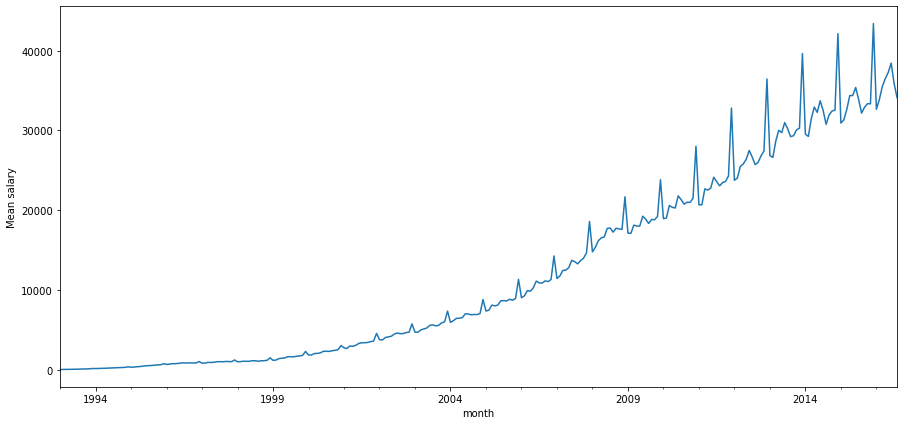

In [4]:
plt.figure(figsize(15,7))
data.salary.plot()
plt.ylabel('Mean salary')
pylab.show()

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

## Part 1: Визуальный анализ ряда

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

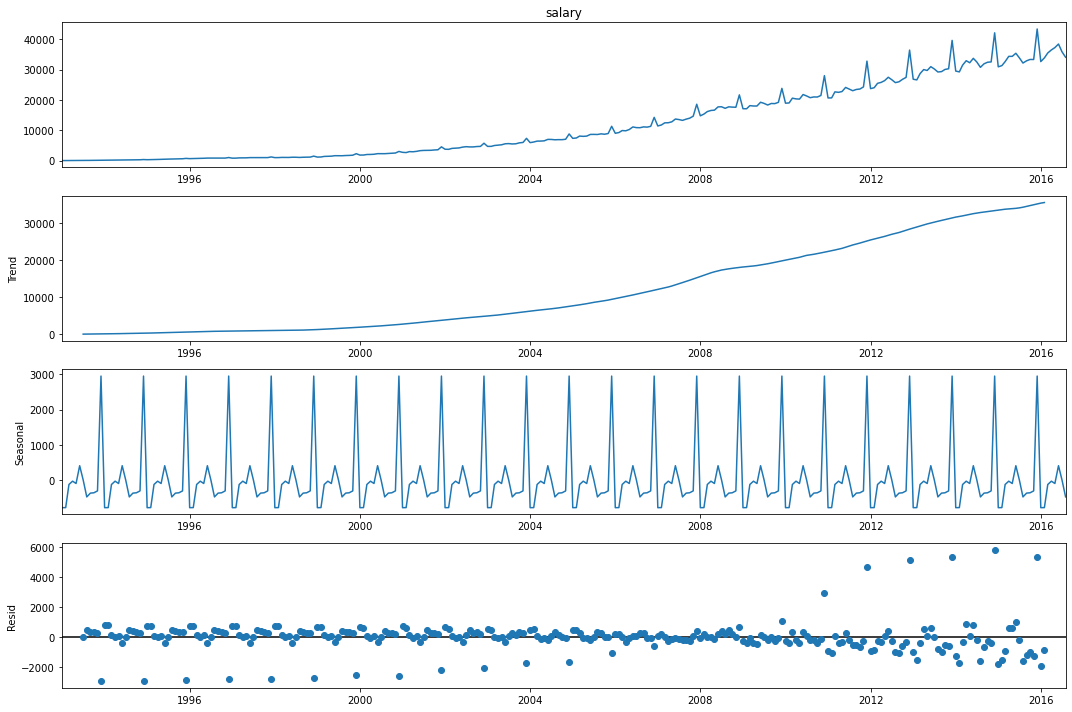

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary)[1])

## Part 2: Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [6]:
data['salary_box'], lmbda = stats.boxcox(data.salary) # Возвращает ряд после преобразования и лямбда критерий

Построим график ряда после преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


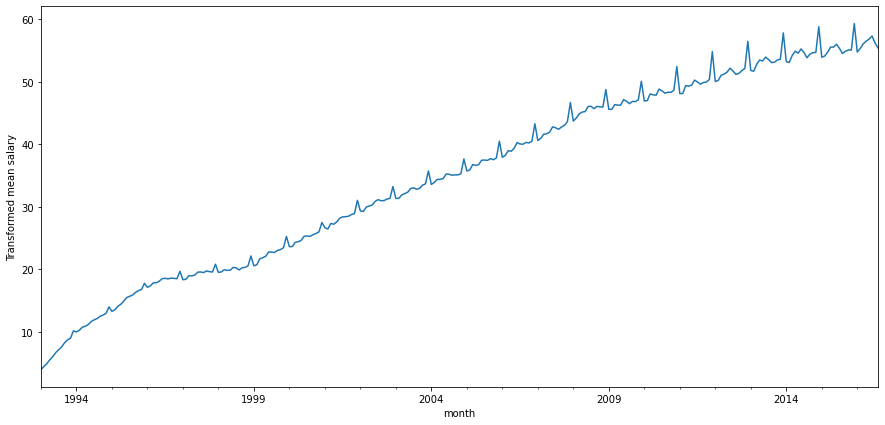

In [7]:
plt.figure(figsize(15,7))
data.salary_box.plot()
plt.ylabel(u'Transformed mean salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box)[1])

## Part 3: Выбор порядка дифференцирования (стационарность)

Критерий Дики-Фуллера отвергает гипотезу стационарности, и визуально в данных виден тренд. Попробуем для начала сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

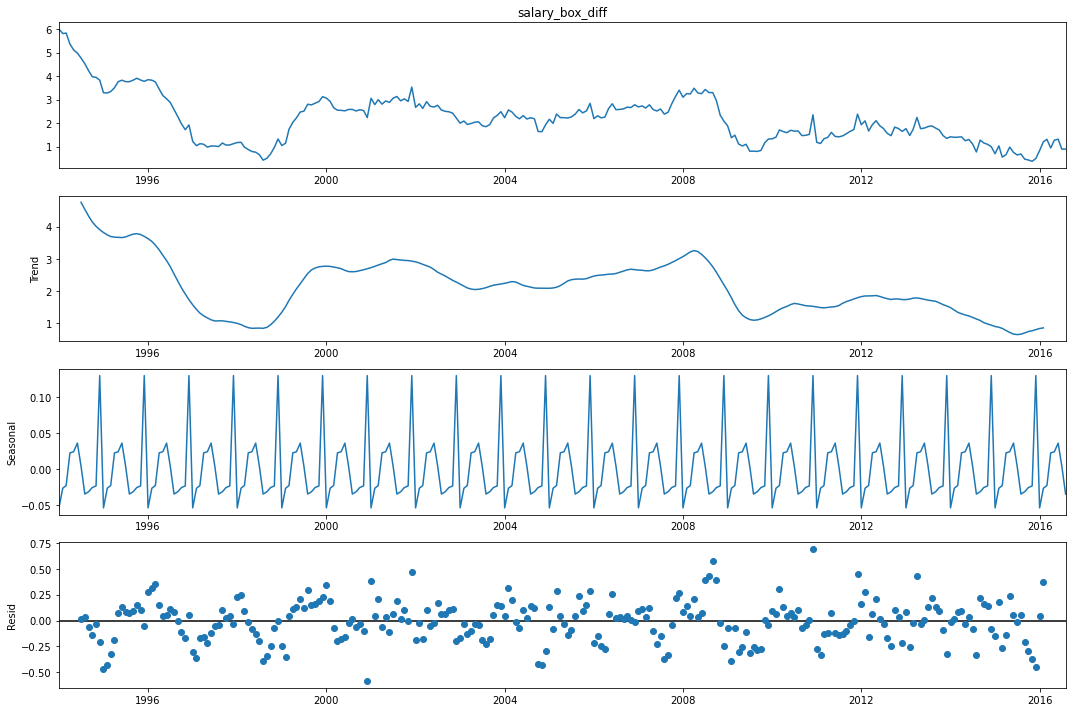

In [8]:
data['salary_box_diff'] = data.salary_box - data.salary_box.shift(12)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

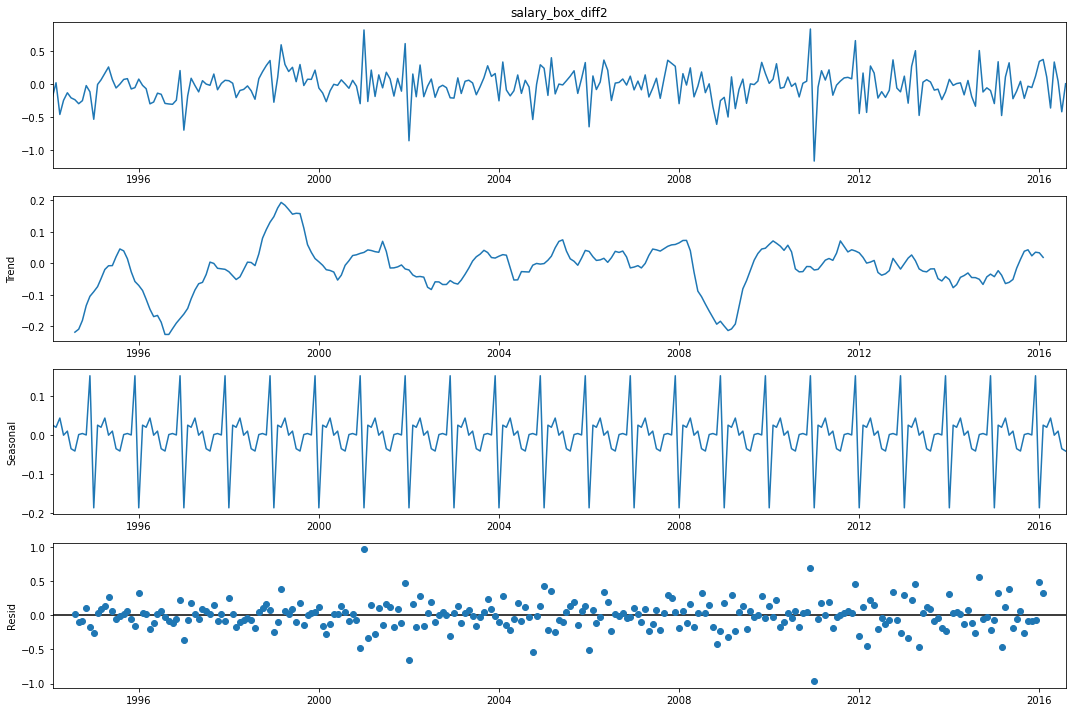

In [9]:
data['salary_box_diff2'] = data.salary_box_diff - data.salary_box_diff.shift(1)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Part 4: Выбор начальных приближений для $p,q,P,Q$

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

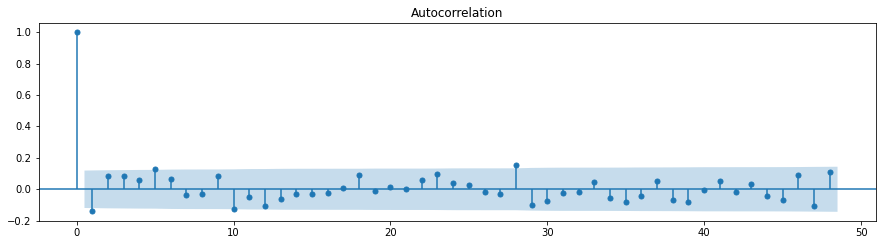

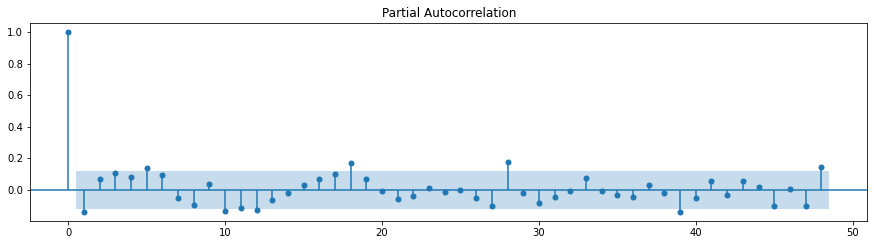

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: $Q=0, q=5, P=1, p=5$

Начальные приближения: $Q = 0, q = 1, P = 4, p = 5$. ($q$ можно было взять больше, но тогда перебор параметров получается слишком большим)

In [11]:
ps = range(0, 6) # from partial autocorrelation
d=1 # simple diffences 
qs = range(0, 6) # from autocorrelation

Ps = range(0, 2) # from partial autocorrelation
D=1 # season diffences 
Qs = range(0, 1) # from autocorrelation

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

## Part 5: Обучение и сравнение моделей-кандидатов, выбор победителя

In [13]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 7min 25s, sys: 6min 32s, total: 13min 58s
Wall time: 1min 56s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
71  (5, 5, 1, 0) -25.211064
59  (4, 5, 1, 0) -24.018303
70  (5, 5, 0, 0) -22.080768
28  (2, 2, 0, 0) -21.488595
29  (2, 2, 1, 0) -21.473461


/home/fantast/anaconda3/envs/coursera/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Лучшая модель:

In [15]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood                  24.606
Date:                             Sat, 27 Feb 2021   AIC                            -25.211
Time:                                     21:30:14   BIC                             18.014
Sample:                                 01-01-1993   HQIC                            -7.856
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2186      1.134     -0.193      0.847      -2.442       2.005
ar.L2          0.2416      

/home/fantast/anaconda3/envs/coursera/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Part 6: Анализ остатков построенной модели

при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p,q,P,Q$

Критерий Стьюдента: p=0.170267
Критерий Дики-Фуллера: p=0.000000


/home/fantast/anaconda3/envs/coursera/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


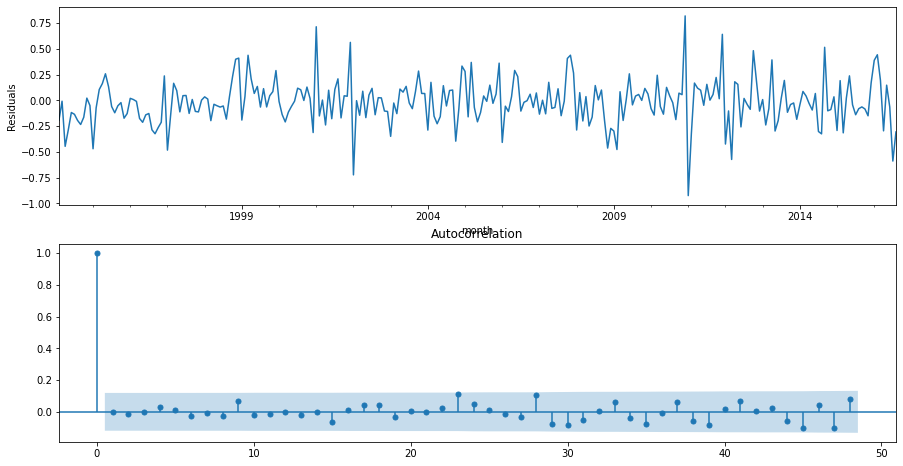

In [16]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

/home/fantast/anaconda3/envs/coursera/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


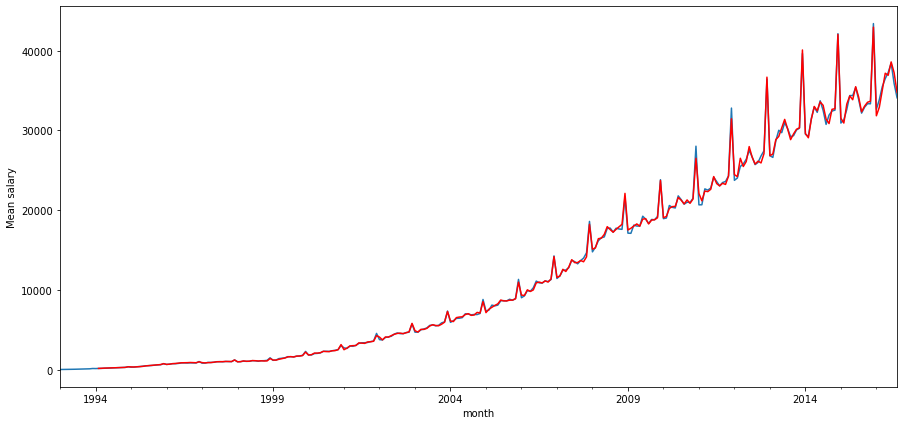

In [17]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.salary.plot()
data.model[13:].plot(color='r')
plt.ylabel('Mean salary')
pylab.show()

## Part 7: Прогнозирование с помощью финальной модели.

/home/fantast/anaconda3/envs/coursera/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


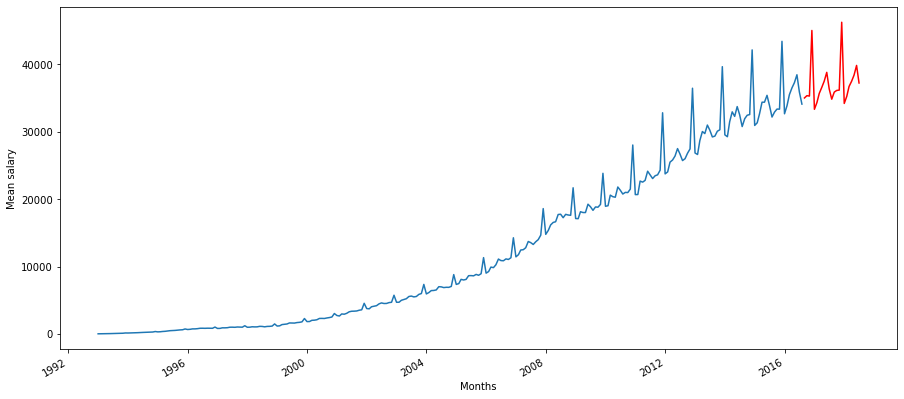

In [18]:
data2 = data[['salary']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
data2.salary.plot()
data2.forecast.plot(color='r')
plt.ylabel('Mean salary')
plt.xlabel('Months')
pylab.show()

In [21]:
data2.shape, data.shape

/home/fantast/anaconda3/envs/coursera/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((308, 2), (284, 5))

Построеный прогноз соотвествует тренду и имеет схожую дисперсию. Можно считать, что модель успешно построила прогноз для $ARIMA(p,d,q)x(P,D,Q)$